In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow_addons.losses import GIoULoss
from tensorflow_addons.losses import giou_loss
import json
import numpy as np
import tensorflow as tf

from tf_common import plot_history

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
MODE = 'HARD_CORE'

In [4]:
def gen_rect(img_size, sqr_size, pad):
    """ Create a dummy rectangle image. """
    # Generate a point in the upper left region.
    x, y = np.random.randint(0, img_size // 2, 2)

    # Generate a random width and height.
    w, h = np.random.randint(sqr_size // 2, sqr_size , 2)

    if y + h > img_size:
        h = img_size - y - 1

    if x + w > img_size:
        w = img_size - x - 1

    if MODE == 'HARD_CORE':
        img = np.random.randint(0, 100, size=(img_size, img_size))
        img[y:y + h, x:x + w] = np.random.randint(100, 255, size=(h, w))
    else:
        img = np.zeros((img_size, img_size))
        img[y:y + h, x:x + w] = 1

    # Notice the *pad* for allowing a broader bounding box.
    # For GIoULoss: [y_min, x_min, y_max, x_max]
    bbox = [
        max(y - pad, 0),
        max(x - pad, 0), 
        y + h + pad,
        x + w + pad
        ]
    return img, bbox

In [5]:
def create_data(num_imgs, img_size, pad=0, sqr_size=None):
    """ Create database of images and labels. """
    bbox = np.empty((num_imgs, 4), dtype=float)
    imgs = np.empty((num_imgs, img_size, img_size), dtype=float)

    if sqr_size is None:
        # Use 2/3 of width by default.
        sqr_size =  2 * img_size // 3

    for i_img in range(num_imgs):
        img, xywh = gen_rect(img_size, sqr_size, pad)
        imgs[i_img, :] = img
        bbox[i_img, :] = xywh

    return imgs, bbox

In [6]:
def overlap(bbox1, bbox2):
    """ Calculate negative overlap between two bounding boxes. """
    return 1 - giou_loss(bbox1, bbox2, mode='iou')

In [7]:
def view_image(img, preds, actual=None, saveas=None):
    """ Display the image of a rectangle and bounding box. """
    y, x, y_m, x_m = preds
    w = x_m - x
    h = y_m - y

    plt.close('all')
    rect = Rectangle((x, y), w, h, ec='r', fc='none')
    plt.imshow(img, cmap='Greys', interpolation='none', 
               origin='lower', extent=[0, img.shape[0], 0, img.shape[1]])
    plt.gca().add_patch(rect)

    if actual is not None:
        iou = overlap(preds, actual)
        plt.title(F'IOU: {iou:.2f}', color='r')

    if saveas is None:
        saveas = 'plot_prediction.png'

    plt.savefig(saveas, dpi=200)

In [8]:
def get_model(imp_shape):
    """ Generate model for single channel input. """
    opts = dict(
        strides=(1, 1),
        padding='same', 
        activation='relu'
    )

    layers = [
        # (1) convolution layer.
        Conv2D(4, 3, input_shape=imp_shape),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(8, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(16, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(32, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(64, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
    
        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(128, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(256, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(512, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (3) flattening.
        Flatten(),
        BatchNormalization(axis=-1),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4)
    ]
    return Sequential(layers)

In [9]:
def get_model_and_data(num_imgs, img_size, pad, phi, rnd):
    """ Generate and preprocess model data. """
    # Create random data.
    X, y = create_data(num_imgs, img_size, pad=pad)
    X = X.reshape((-1, img_size, img_size, 1))

    # Perform global train test split.
    split = train_test_split(X, y, train_size=phi, random_state=rnd)
    train_X, tests_X, train_y, tests_y = split

    # Compute mean of *train* alone.
    mu = train_X.mean()
    std = train_X.std()

    # Transform input datasets.
    train_X = (train_X - mu) / std
    tests_X = (tests_X - mu) / std

    # Keep first image from training.
    # view_image(train_X[0], train_y[0], saveas='plot_sample.png')

    # Create model with proper dimensions.
    model = get_model((*train_X[0].shape,))

    return model, (train_X, tests_X, train_y, tests_y)

In [10]:
rnd = 42
phi = 0.8
vld = 0.2
pad = 1
num_imgs = 50_000
img_size = 64 * 1

In [11]:
model, (train_X, tests_X, train_y, tests_y) =\
    get_model_and_data(num_imgs, img_size, pad, phi, rnd)

losses = [GIoULoss(mode='iou'), 'mse']
weights = [1, 1]
metric = 'mae'
optim = 'SGD'
optim = 'adam'

# Compile model with loss and optimizer.
model.compile(optimizer=optim, 
              loss=losses, 
              loss_weights=weights,
              metrics=[metric])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 4)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 4)        16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                        

In [12]:
# Create a callback for early training end.
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Train model with a validation set.
history = model.fit(train_X, train_y, epochs=100, batch_size=32,
                    validation_split=0.1, callbacks=[early])

Epoch 1/100
1125/1125 [==============================] - 79s 69ms/step - loss: 0.4274 - mae: 7.7316 - val_loss: 0.2406 - val_mae: 2.3424
Epoch 2/100
1125/1125 [==============================] - 76s 68ms/step - loss: 0.2147 - mae: 2.0492 - val_loss: 0.1758 - val_mae: 1.7765
Epoch 3/100
1125/1125 [==============================] - 77s 68ms/step - loss: 0.1652 - mae: 1.5014 - val_loss: 0.1311 - val_mae: 1.1801
Epoch 4/100
1125/1125 [==============================] - 78s 69ms/step - loss: 0.1401 - mae: 1.2464 - val_loss: 0.1108 - val_mae: 0.9754
Epoch 5/100
1125/1125 [==============================] - 78s 70ms/step - loss: 0.1262 - mae: 1.1090 - val_loss: 0.1145 - val_mae: 1.0010
Epoch 6/100
1125/1125 [==============================] - 77s 69ms/step - loss: 0.1175 - mae: 1.0260 - val_loss: 0.1097 - val_mae: 0.9605
Epoch 7/100
1125/1125 [==============================] - 78s 69ms/step - loss: 0.1143 - mae: 0.9951 - val_loss: 0.1029 - val_mae: 0.8928
Epoch 8/100
1125/1125 [==================

313/313 [==============================] - 4s 11ms/step - loss: 0.0762 - mae: 1.1022


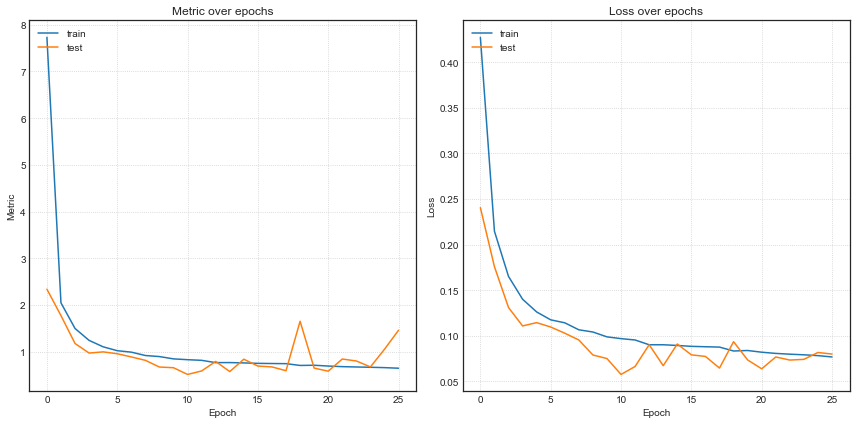

In [13]:
# Evaluate over test set.
results = model.evaluate(tests_X, tests_y, verbose=1)

# View training history.
plot_history(history.history, metric)

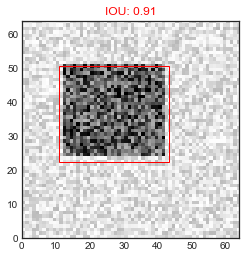

In [14]:
# Make predictions for visualization.
preds = model.predict(tests_X)

no_choices = 10
for k in np.random.choice(range(len(tests_X)), no_choices):
    saveas = F'plot_prediction_{k:04}.png'
    view_image(tests_X[k], preds[k], tests_y[k], saveas=saveas)

In [15]:
# Save model for re-use.
# model.save('model.h5')

# with open('metrics.json', 'w') as fp:
#     json.dump({'loss': results}, fp)

In [16]:
results

[0.07615195214748383, 1.1021751165390015]